In [ ]:
import numpy as np
import matplotlib.pyplot as plt # 시각화

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision  # 데이터 셋, 아키텍처 모델, 이미지 변환 기능으로 구성되어 있는 패키지
import torchvision.transforms as transforms # 이미지 전처리
from torch.utils.data import Dataset, DataLoader

# 코랩 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
transforms = transforms.Compose([transforms.ToTensor()]) # 이미지를 텐서로 전처리 하는 과정

train_DS = torchvision.datasets.FashionMNIST( # FashionMNIST라는 데이터를 가져옴 (DS: dataset의 약자)
    "/content/drive/MyDrive/Colab Notebooks", # 저장 경로
    download=True, # 다운로드
    train=True, # 학습 데이터
    transform=transforms # 이미지 전처리
)

test_DS = torchvision.datasets.FashionMNIST(
    "/content/drive/MyDrive/Colab Notebooks", # 저장 경로
    download=True, # 다운로드
    train=False, # 학습 데이터 X
    transform=transforms # 이미지 전처리
)

In [ ]:
# Hyper parameter
batch_size = 100
epochs = 20
lr = 1e-3

train_DL = torch.utils.data.DataLoader( # DL: data loader의 약자
    train_DS, # train_dataset에서 데이터를 가져옴
    batch_size=batch_size, # batchsize 지정
    shuffle=True # 데이터 섞음
)

test_DL = torch.utils.data.DataLoader( #
    test_DS, # test dataset에서 데이터를 가져옴
    batch_size=batch_size,
    shuffle=True
)

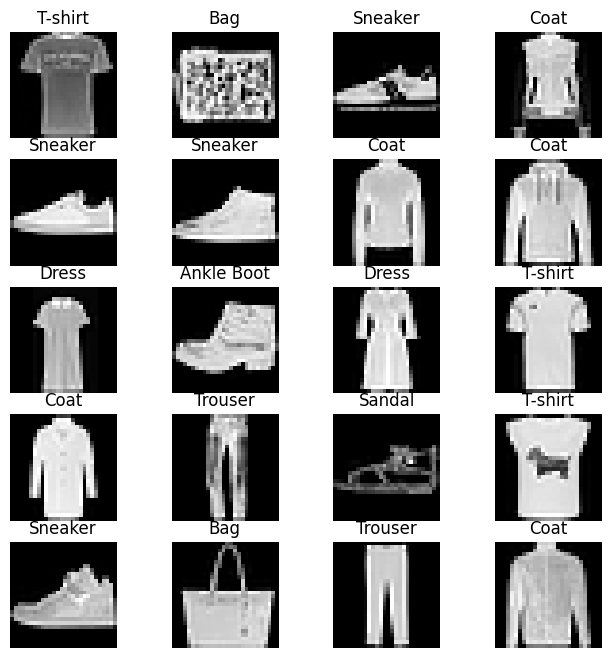

In [ ]:
labels = { # 딕셔너리 형태로 idx와 label 지정
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(8, 8))
cols, rows = 4, 5

for i in range(1, cols*rows+1):
    img_xy = np.random.randint(len(train_DS)) # 전체 train_ds 중에서 임의의 데이터 한 개를 정함
    img = train_DS[img_xy][0][0, :, :] # 임의의 값으로 뽑은 img_xy에서 train_ds에 img_xy번째에 해당하는 이미지를 가져옴 (이때 출력을 하면 텐서 형태로 출력)
    fig.add_subplot(rows, cols, i) # 시각화
    plt.title(labels[train_DS[img_xy][1]]) # title을 각각의 class에 맞게 지정
    plt.axis('off') # 주변 경계선 다 지움
    plt.imshow(img, cmap='gray') # 이미지를 흑백으로 출력
plt.show() # 이미지 출력

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64*6*6, 600)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1) # 여기 뜯어볼 것
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

model = ConvNet().to(device)

# x = torch.randn(32, 1, 28, 28).to(device) # Fashion MNIST 이미지 크기 28×28
# print(model(x).shape)
# 위 코드는 나오는 shape의 크기를 알기 위함

Epoch: 1, train loss: 0.45
--------------------
Epoch: 2, train loss: 0.299
--------------------
Epoch: 3, train loss: 0.259
--------------------
Epoch: 4, train loss: 0.234
--------------------
Epoch: 5, train loss: 0.22
--------------------
Epoch: 6, train loss: 0.203
--------------------
Epoch: 7, train loss: 0.187
--------------------
Epoch: 8, train loss: 0.173
--------------------
Epoch: 9, train loss: 0.164
--------------------
Epoch: 10, train loss: 0.155
--------------------
Epoch: 11, train loss: 0.145
--------------------
Epoch: 12, train loss: 0.133
--------------------
Epoch: 13, train loss: 0.128
--------------------
Epoch: 14, train loss: 0.118
--------------------
Epoch: 15, train loss: 0.115
--------------------
Epoch: 16, train loss: 0.108
--------------------
Epoch: 17, train loss: 0.102
--------------------
Epoch: 18, train loss: 0.094
--------------------
Epoch: 19, train loss: 0.091
--------------------
Epoch: 20, train loss: 0.087
--------------------


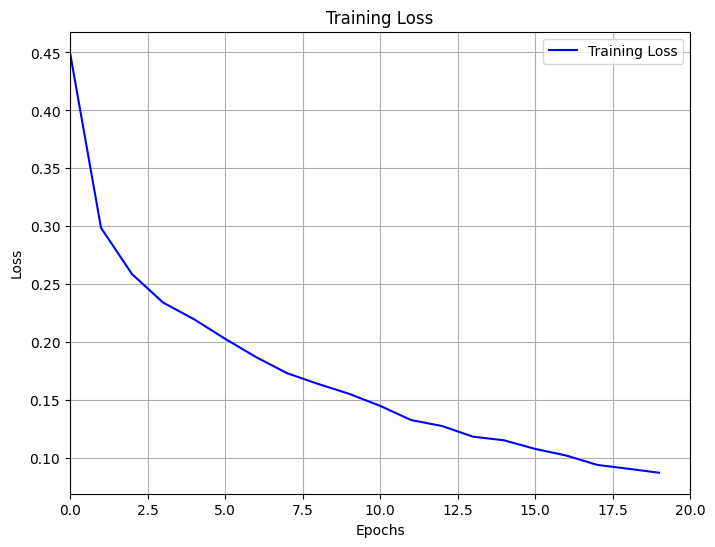

In [ ]:
criterion = nn.CrossEntropyLoss() # 크로스엔트로피를 손실함수로 지정
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 아담을 옵티마이저로 지정

def Train(model, train_DL, criterion, optimizer, EPOCH, DEVICE):
    loss_history =[]
    NoT = len(train_DL.dataset) # 전체 데이터 갯수

    model.train() # 모델을 학습 모드로 변경
    for ep in range(EPOCH): # epoch만큼 반복
        rloss = 0 # running loss
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE) # 이미지
            y_batch = y_batch.to(DEVICE) # 이미지에 대한 정답
            y_hat = model(x_batch) # 에측값 y_hat
            loss = criterion(y_hat, y_batch) # 손실함수에서 계산된 값을 Loss에 저장
            optimizer.zero_grad() # 값 누적 방지
            loss.backward() # 그라디언트 계산
            optimizer.step() # 가중치 업데이트
            loss_b = loss.item() * x_batch.shape[0] # 100(batch_size)개에 대한 loss 합을 계산
            rloss += loss_b # running loss에 값을 더함
        loss_e = rloss/NoT # running loss / 데이터 전체 갯수
        loss_history += [loss_e] # loss_history에 한 epoch당 loss의 평균값 추가
        print(f"Epoch: {ep+1}, train loss: {round(loss_e,3)}")
        print("-"*20)

    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, epochs)
    plt.show()

Train(model, train_DL, criterion, optimizer, epochs, device)

In [ ]:
def Test(model, test_DL, DEVICE):
    model.eval() # 테스트 모드로 설정
    with torch.no_grad(): # 값 누적 방지
        rcorrect = 0 # 맞은 갯수 = 0
        for x_batch, y_batch in test_DL: # test_DL 크기만큼 반복
            x_batch = x_batch.to(DEVICE) # 이미지
            y_batch = y_batch.to(DEVICE) # 이미지에 대한 정답
            y_hat = model(x_batch) # 예측값 y_hat
            pred = y_hat.argmax(dim=1) # dim=1에 대하여 최댓값을 pred에 저장
            corrects_b = torch.sum(pred == y_batch).item() # 예측값과 정답이 맞다면 숫자형태로 변환하여 corrects_b에 저장
            rcorrect += corrects_b # rcorrect에 corrects_b값을 더함

        accuracy_e = rcorrect/len(test_DL.dataset)*100 # 정확도 = 전체 맞은 갯수 / (데이터 갯수 * 100)
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")


Test(model, test_DL, device)

# 출력: Test accuracy: 9083/10000 (90.8 %)

Test accuracy: 9077/10000 (90.8 %)


In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Fashion_ConvNet.pt' # 저장할 경로
torch.save(model, save_path) # 모델, 저장할 경로

In [ ]:
load_model = torch.load(save_path, device) # 모델이 저장된 경로에 device로 모델을 불러옴

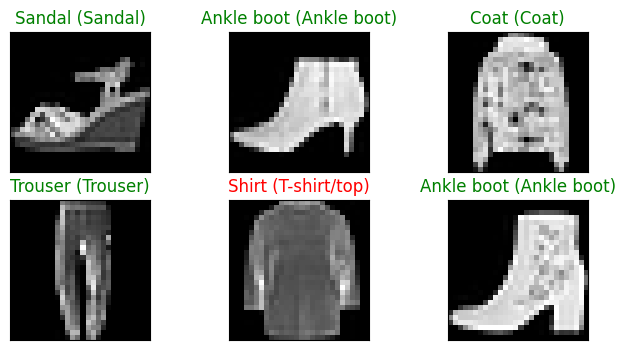

In [ ]:
def Test_plot(model, test_DL, DEVICE):
    model.eval() # 테스트 모드로 설정
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL)) # 데이터로더에서 한 배치를 가져옴 (데이터를 한 국자 뜬다.)
        x_batch = x_batch.to(DEVICE)
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim=1) # 확률이 가장 높은 class 선택

    x_batch = x_batch.to("cpu") # numpy를 돌리기 위해서는 cpu로 설정해야함

    plt.figure(figsize=(8,4))
    for idx in range(6): # 6번 반복
        plt.subplot(2,3, idx+1, xticks=[], yticks=[]) #
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap="gray")
				# 이미지를 pytorch에 맞게 차원을 변경한 후 차원을 축소시켜 흑백 이미지 출력
        pred_class = test_DL.dataset.classes[pred[idx]] # test_DL에서 예측한 값을 클래스로 변한
        true_class = test_DL.dataset.classes[y_batch[idx]] # test_DL에서 실제 값을 클래스로 변환
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r")
				# 서로 일치하면 초록색, 그렇지 않으면 빨간색으로 출력

Test_plot(load_model, test_DL, device)